In [1]:
%reset -f
%matplotlib notebook
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from aux import Generic, GenericFlexible
from ntwk import LIFNtwk
from disp import raster, set_font_size

# Scale-free graphs

In [2]:
def directed_power_law_adj(n, gamma, seed):
    """
    Construct an adjacency matrix with equal but uncorrelated power-law
    in- and out-degree distributions.
    """
    deg_possible = np.arange(n, dtype=float)
    
    # get normalized power-law probability over deg_possible
    p_unnormed = (deg_possible + 1) ** (-gamma)
    p_normed = p_unnormed / np.sum(p_unnormed)
    
    # sample in-deg from power-law distribution
    np.random.seed(seed)
    in_deg = np.random.choice(deg_possible.astype(int), n, replace=True, p=p_normed)
    
    # shuffle out-deg to break corr. with in-deg
    out_deg = in_deg[np.random.permutation(n)]
    
    g = nx.directed_configuration_model(in_deg, out_deg, create_using=nx.DiGraph(), seed=seed)
    
    adj = np.array(nx.adjacency_matrix(g, weight=None).T.todense())
    np.fill_diagonal(adj, 0)
    
    return adj.astype(bool)

<IPython.core.display.Javascript object>


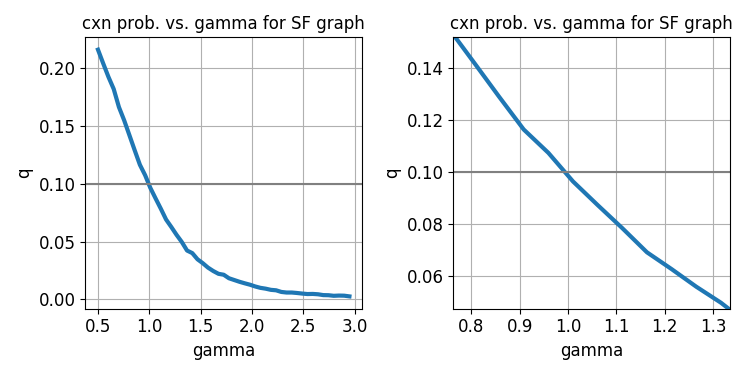

In [3]:
SEED = 0
N = 100

gammas = np.linspace(0.5, 3)[:-1]
qs = np.nan * np.zeros(gammas.shape)

for ctr, gamma in enumerate(gammas):
    
    # get cxn prob
    c_rcr = directed_power_law_adj(N, gamma, SEED)
    q = c_rcr.sum() / (N*(N-1))
    
    qs[ctr] = q
    
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.75), tight_layout=True)

for ax in axs:
    ax.plot(gammas, qs, lw=3)
    ax.axhline(.1, color='gray')
    ax.set_xlabel('gamma')
    ax.set_ylabel('q')
    ax.set_title('cxn prob. vs. gamma for SF graph')
    
    ax.grid()

    set_font_size(ax, 12)

# Scale-free LIF network

In [4]:
def sf_ntwk(P, STORE=None):
    """Make a new LIF ntwk with scale-free connectivity."""
    # make upstream weight matrix
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = directed_power_law_adj(P.n, P.gamma, P.seed)
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

In [5]:
def run(ntwk, P, STORE=None):
    """Construct SF ntwk and run smln."""
    
    # make noisy input
    np.random.seed(P.seed)
    t = np.arange(0, P.dur, P.dt)
    spks_up = np.random.poisson(P.frq_up * P.dt, (len(t), P.n))
    spks_up[t >= P.stm_off] = 0
    
    # run ntwk
    rsp = ntwk.run(spks_up, P.dt)
    
    STORE.spks_up = spks_up.copy()
    
    return rsp, STORE

## Reasonable parameters

### Unconnected network

In [6]:
# params
P = Generic(
    # general
    dt=0.0005,
    
    # ntwk
    n=100,
    gamma=1,
    t_m=0.05,
    e_l=-0.068,
    v_th=-0.036,
    v_reset=-.068,
    t_r=0.002,
    e_e=0,
    t_e=0.002,
    w_e_rcr=0,  # 0 for no recurrence
    w_e_up=0.01,
    
    # input
    frq_up=600,  # 600 for no recurrence
    stm_off=10,
    
    # smln
    dur=11,
    seed=0)

# make ntwk and run
STORE = GenericFlexible()

ntwk = sf_ntwk(P, STORE)[0]
rsp = run(ntwk, P, STORE)[0]

# get firing rate distribution
t_wdw = 0.2, 10
t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
fr_0 = rsp.spks[t_mask, :].sum(0) / (t_wdw[1] - t_wdw[0])

# get correlation distribution
t_bin_size = 0.01
t_bins = np.arange(t_wdw[0], t_wdw[1]+t_bin_size, t_bin_size)

spk_cts = []
for t_bin_start, t_bin_end in zip(t_bins[:-1], t_bins[1:]):
    t_bin_mask = (t_bin_start <= rsp.ts) & (rsp.ts < t_bin_end)
    spks_t_bin = rsp.spks[t_bin_mask, :]
    spk_cts.append(spks_t_bin.sum(0))
    
corrs = np.corrcoef(spk_cts, rowvar=False)
corrs_0 = corrs[np.triu_indices(P.n, 1)]

### Recurrent network

In [7]:
P = Generic(
    # general
    dt=0.0005,
    
    # ntwk
    n=100,
    gamma=1,
    t_m=0.05,
    e_l=-0.068,
    v_th=-0.036,
    v_reset=-.068,
    t_r=0.002,
    e_e=0,
    t_e=0.002,
    w_e_rcr=0.01,  # 0 for no recurrence
    w_e_up=0.01,
    
    # input
    frq_up=400,  # 600 for no recurrence
    stm_off=10,
    
    # smln
    dur=11,
    seed=0)

STORE = GenericFlexible()

ntwk = sf_ntwk(P, STORE)[0]
rsp = run(ntwk, P, STORE)[0]

<IPython.core.display.Javascript object>


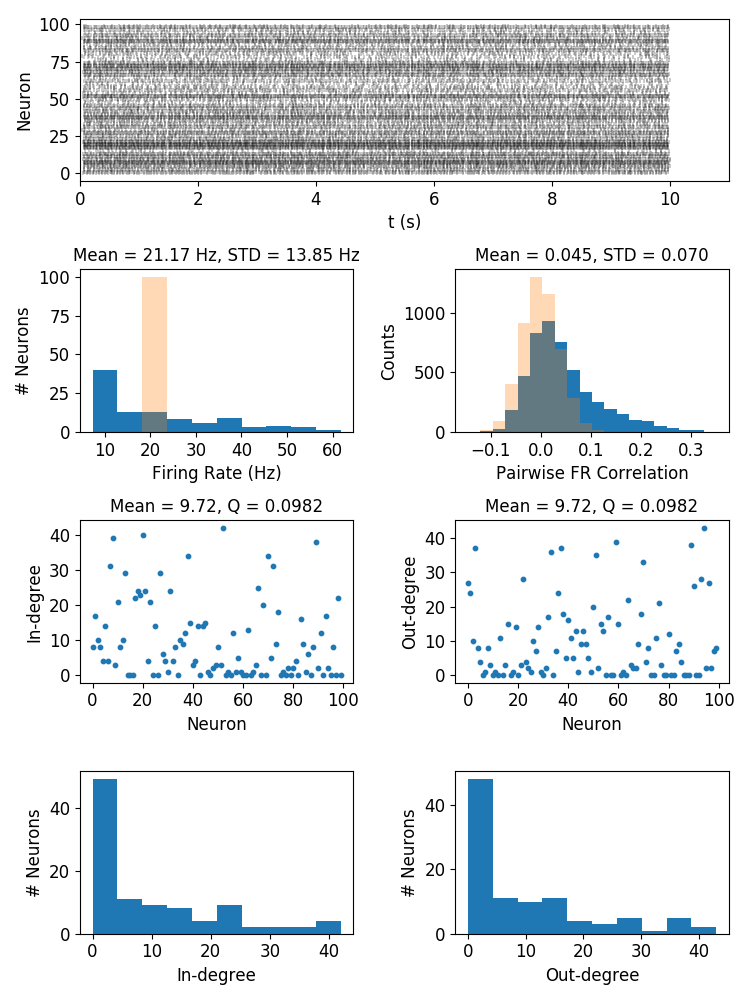

In [8]:
# make plots
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(7.5, 10), tight_layout=True)
axs = []

# raster
axs.append(fig.add_subplot(gs[0, :]))
raster(axs[-1], rsp.ts, rsp.spks)

# firing rate distribution
axs.append(fig.add_subplot(gs[1, 0]))

t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
fr = rsp.spks[t_mask, :].sum(0) / (t_wdw[1] - t_wdw[0])
cts, bins = np.histogram(fr)
axs[-1].hist(fr, bins=bins, zorder=0)
axs[-1].hist(fr_0, bins=bins, zorder=1, alpha=0.3)
axs[-1].set_xlabel('Firing Rate (Hz)')
axs[-1].set_ylabel('# Neurons')
axs[-1].set_title('Mean = {0:.2f} Hz, STD = {1:.2f} Hz'.format(fr.mean(), fr.std()))

# correlation distribution
axs.append(fig.add_subplot(gs[1, 1]))

t_bins = np.arange(t_wdw[0], t_wdw[1]+t_bin_size, t_bin_size)

spk_cts = []
for t_bin_start, t_bin_end in zip(t_bins[:-1], t_bins[1:]):
    t_bin_mask = (t_bin_start <= rsp.ts) & (rsp.ts < t_bin_end)
    spks_t_bin = rsp.spks[t_bin_mask, :]
    spk_cts.append(spks_t_bin.sum(0))
    
corrs = np.corrcoef(spk_cts, rowvar=False)
corrs = corrs[np.triu_indices(P.n, 1)]

cts, bins = np.histogram(corrs, bins=20)
axs[-1].hist(corrs, bins=bins, zorder=0)
axs[-1].hist(corrs_0, bins=bins, zorder=1, alpha=0.3)
axs[-1].set_xlabel('Pairwise FR Correlation')
axs[-1].set_ylabel('Counts')
axs[-1].set_title('Mean = {0:.3f}, STD = {1:.3f}'.format(corrs.mean(), corrs.std()))

# in & out-degree distributions
axs.append(fig.add_subplot(gs[2, 0]))
cells = np.arange(P.n)
in_degs = [STORE.g.in_degree(cell) for cell in cells]
axs[-1].scatter(cells, in_degs, s=10)
axs[-1].set_xlabel('Neuron')
axs[-1].set_ylabel('In-degree')
axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
    np.mean(in_degs), np.mean(in_degs)/(P.n - 1)))

axs.append(fig.add_subplot(gs[2, 1]))
cells = np.arange(P.n)
out_degs = [STORE.g.out_degree(cell) for cell in cells]
axs[-1].scatter(cells, out_degs, s=10)
axs[-1].set_xlabel('Neuron')
axs[-1].set_ylabel('Out-degree')
axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
    np.mean(out_degs), np.mean(out_degs)/(P.n - 1)))

axs.append(fig.add_subplot(gs[3, 0]))
axs[-1].hist(in_degs, bins=10)
axs[-1].set_xlabel('In-degree')
axs[-1].set_ylabel('# Neurons')

axs.append(fig.add_subplot(gs[3, 1]))
axs[-1].hist(out_degs, bins=10)
axs[-1].set_xlabel('Out-degree')
axs[-1].set_ylabel('# Neurons')

for ax in axs:
    set_font_size(ax, 12)

# Excitabilty analysis

In [9]:
from copy import deepcopy


def run_e_leak_change_smlns(make_ntwk, nrns, e_leaks, P, STORE):
    """
    Run identical simulations, except for a set of neurons with
    modified leak potentials.
    """
    
    ntwk_0 = make_ntwk(P, STORE)[0]
    rsp_0 = run(ntwk_0, P, STORE)[0]
    
    rsp_0.ntwk = deepcopy(ntwk_0)
    
    ntwk_1 = deepcopy(ntwk_0)
    ntwk_1.e_l[nrns] = e_leaks
    ntwk_1.v_reset[nrns] = e_leaks
    
    rsp_1 = run(ntwk_1, P, STORE)[0]
    
    rsp_1.ntwk = deepcopy(ntwk_1)
    
    return rsp_0, rsp_1


def get_frs(rsp, P):
    """Get firing rate distribution over cells."""
    
    t_wdw = (0.5, P.stm_off)
    
    t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
    spks = rsp.spks[t_mask, :]
    
    fr = spks.sum(0) / (t_wdw[1] - t_wdw[0])
    
    return fr


def dual_raster(ax, rsp_0, rsp_1, nrns_shown=None, nrns_changed=None):
    """Show two overlaid raster plots."""
    if nrns_shown is None:
        nrns_shown = range(rsp_0.ntwk.n)
        
    if nrns_changed is None:
        nrns_changed = []
        
    raster(ax, rsp_0.ts, rsp_0.spks, order=nrns_shown, c='b', lw=1, zorder=1)
    raster(ax, rsp_1.ts, rsp_1.spks, order=nrns_shown, c='r', lw=1, zorder=0)
    
    for nrn in nrns_changed:
        if nrn in nrns_shown:
            y = nrns_shown.index(nrn)
            ax.axhline(y, color='gray', alpha=0.4)
    
    return ax


def run_example(make_ntwk, nrns, e_leak, P, STORE):
    rsp_0, rsp_1 = run_e_leak_change_smlns(make_ntwk, nrns, e_leak, P, STORE)

    fig, axs = plt.subplots(2, 1, figsize=(7.5, 5), tight_layout=True)

    dual_raster(axs[0], rsp_0, rsp_1, nrns_changed=nrns)

    axs[0].set_xlim(0, .35)
    axs[0].set_facecolor((.95, .95, .95))

    nrns = range(rsp_0.ntwk.n)

    axs[1].bar(nrns, get_frs(rsp_0, P), color='b', alpha=0.5, align='center')
    axs[1].bar(nrns, get_frs(rsp_1, P), color='r', alpha=0.5, align='center')

    axs[1].set_xlabel('Neuron')
    axs[1].set_ylabel('Average firing rate (Hz)')
    
    return fig, axs

<IPython.core.display.Javascript object>


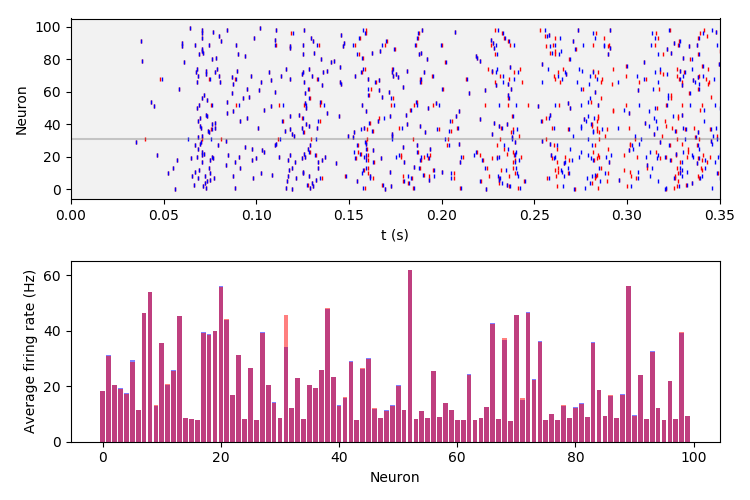

In [10]:
run_example(sf_ntwk, [31], -0.06, P, STORE);

<IPython.core.display.Javascript object>


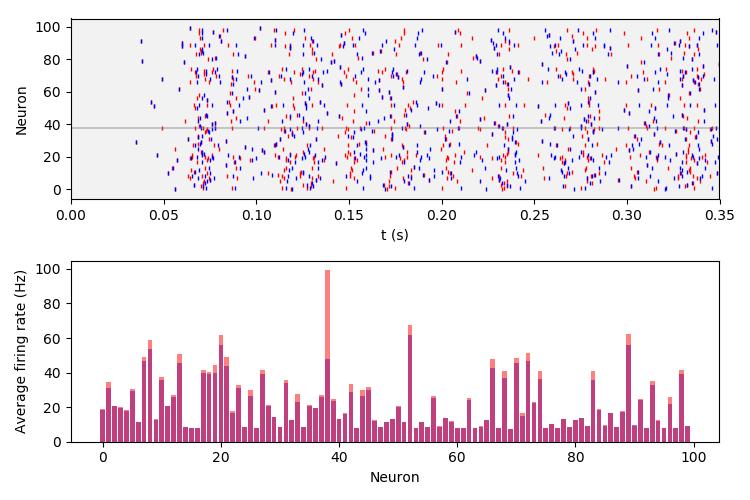

In [11]:
run_example(sf_ntwk, [38], -0.05, P, STORE);

# Excitability influence statistics across neurons

In [12]:
import sys

# loop over all neurons in network
STORE = GenericFlexible()

e_leak = -0.05

in_deg = []
out_deg = []

xblt_ifl = []

for nrn in range(P.n):
    
    if nrn % 10 == 0:
        sys.stdout.write('|')
    else:
        sys.stdout.write('.')
        
    rsp_0, rsp_1 = run_e_leak_change_smlns(sf_ntwk, [nrn], e_leak, P, STORE)
    
    # a few checks
    ## both ntwks have equal weight matrices
    assert(np.all(rsp_0.ntwk.ws_rcr['E'] == rsp_1.ntwk.ws_rcr['E'].todense()))
    
    ## in & out-degree
    assert((rsp_0.ntwk.ws_rcr['E'][nrn, :] > 0).sum() == STORE.g.in_degree(nrn))
    assert((rsp_0.ntwk.ws_rcr['E'][:, nrn] > 0).sum() == STORE.g.out_degree(nrn))
    
    # store in- & out-degree
    in_deg.append(STORE.g.in_degree(nrn))
    out_deg.append(STORE.g.out_degree(nrn))
    
    # calc & store excitability influence
    fr_0 = get_frs(rsp_0, P)
    fr_1 = get_frs(rsp_1, P)
    
    # mask out neuron whose excitability was changed
    fr_0[nrn] = np.nan
    fr_1[nrn] = np.nan
    
    xblt_ifl.append(np.sqrt(np.nansum((fr_0 - fr_1)**2)))

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

<IPython.core.display.Javascript object>


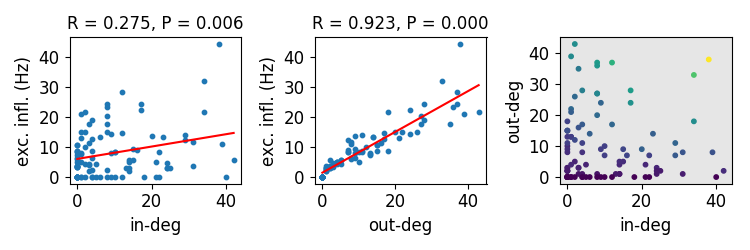

In [13]:
from scipy import stats

# make plots
fig, axs = plt.subplots(1, 3, figsize=(7.5, 7.5/3), tight_layout=True)

axs[0].scatter(in_deg, xblt_ifl, s=10)

r, p = stats.pearsonr(in_deg, xblt_ifl)
slp, icpt = stats.linregress(in_deg, xblt_ifl)[:2]

x = np.array([np.nanmin(in_deg), np.nanmax(in_deg)])
y = slp*x + icpt

axs[0].plot(x, y, c='r')

axs[0].set_xlabel('in-deg')
axs[0].set_ylabel('exc. infl. (Hz)')
axs[0].set_title('R = {0:.3f}, P = {1:.3f}'.format(r, p))

axs[1].scatter(out_deg, xblt_ifl, s=10)

r, p = stats.pearsonr(out_deg, xblt_ifl)
slp, icpt = stats.linregress(out_deg, xblt_ifl)[:2]

x = np.array([np.nanmin(out_deg), np.nanmax(out_deg)])
y = slp*x + icpt

axs[1].plot(x, y, c='r')

axs[1].set_xlabel('out-deg')
axs[1].set_ylabel('exc. infl. (Hz)')
axs[1].set_title('R = {0:.3f}, P = {1:.3f}'.format(r, p))

axs[2].scatter(
    in_deg, out_deg, c=xblt_ifl, s=10, 
    vmin=np.nanmin(xblt_ifl), vmax=np.nanmax(xblt_ifl))

axs[2].set_xlabel('in-deg')
axs[2].set_ylabel('out-deg')
axs[2].set_facecolor((.9, .9, .9))

for ax in axs:
    set_font_size(ax, 12)
pass

# Comparing excitability influence distributions across network structures

## Erdos-Renyi

In [14]:
xblt_ifls = {
    'sf': deepcopy(xblt_ifl),
}

def er_ntwk(P, STORE=None):
    """Make a new LIF ntwk with Erdos-Renyi connectivity."""
    # make upstream weight matrix
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = np.random.rand(P.n, P.n) < P.q
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

### Unconnected

In [15]:
# params
P = Generic(
    # general
    dt=0.0005,
    
    # ntwk
    n=100,
    q=0.1,
    t_m=0.05,
    e_l=-0.068,
    v_th=-0.036,
    v_reset=-.068,
    t_r=0.002,
    e_e=0,
    t_e=0.002,
    w_e_rcr=0,  # 0 for no recurrence
    w_e_up=0.01,
    
    # input
    frq_up=600,  # 600 for no recurrence
    stm_off=10,
    
    # smln
    dur=11,
    seed=0)

# make ntwk and run
STORE = GenericFlexible()

ntwk = er_ntwk(P, STORE)[0]
rsp = run(ntwk, P, STORE)[0]

# get firing rate distribution
t_wdw = 0.2, 10
t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
fr_0 = rsp.spks[t_mask, :].sum(0) / (t_wdw[1] - t_wdw[0])

# get correlation distribution
t_bin_size = 0.01
t_bins = np.arange(t_wdw[0], t_wdw[1]+t_bin_size, t_bin_size)

spk_cts = []
for t_bin_start, t_bin_end in zip(t_bins[:-1], t_bins[1:]):
    t_bin_mask = (t_bin_start <= rsp.ts) & (rsp.ts < t_bin_end)
    spks_t_bin = rsp.spks[t_bin_mask, :]
    spk_cts.append(spks_t_bin.sum(0))
    
corrs = np.corrcoef(spk_cts, rowvar=False)
corrs_0 = corrs[np.triu_indices(P.n, 1)]

### Recurrent

In [16]:
P = Generic(
    # general
    dt=0.0005,
    
    # ntwk
    n=100,
    q=0.1,
    t_m=0.05,
    e_l=-0.068,
    v_th=-0.036,
    v_reset=-.068,
    t_r=0.002,
    e_e=0,
    t_e=0.002,
    w_e_rcr=0.01,  # 0 for no recurrence
    w_e_up=0.01,
    
    # input
    frq_up=390,  # 600 for no recurrence
    stm_off=10,
    
    # smln
    dur=11,
    seed=0)

STORE = GenericFlexible()

ntwk = er_ntwk(P, STORE)[0]
rsp = run(ntwk, P, STORE)[0]

<IPython.core.display.Javascript object>


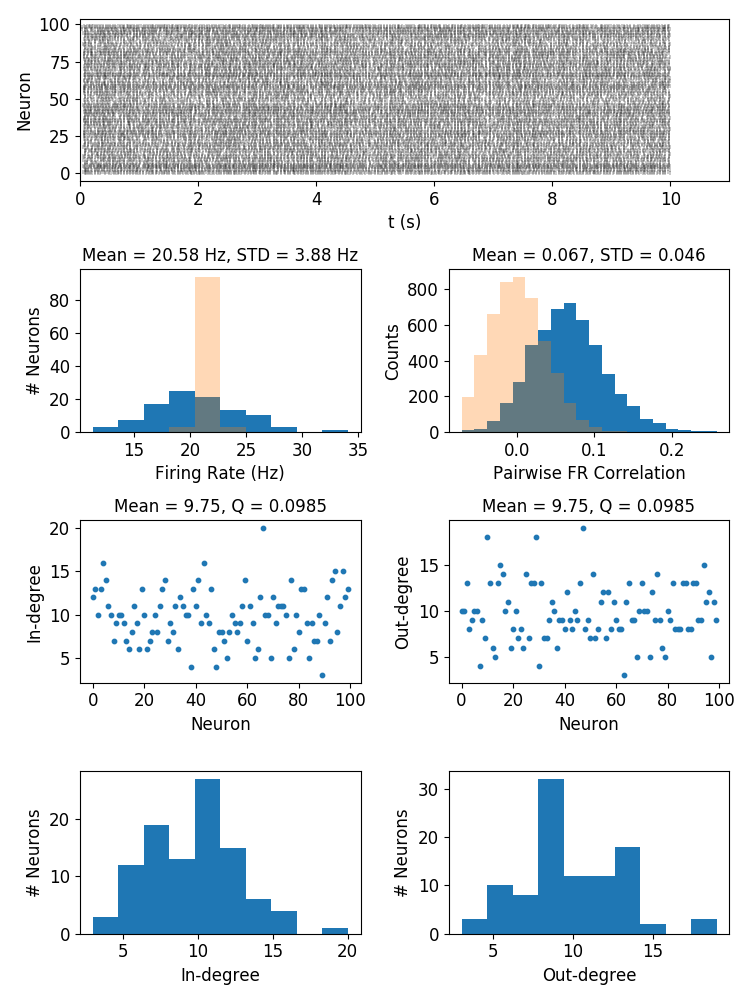

In [17]:
# make plots
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(7.5, 10), tight_layout=True)
axs = []

# raster
axs.append(fig.add_subplot(gs[0, :]))
raster(axs[-1], rsp.ts, rsp.spks)

# firing rate distribution
axs.append(fig.add_subplot(gs[1, 0]))

t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
fr = rsp.spks[t_mask, :].sum(0) / (t_wdw[1] - t_wdw[0])
cts, bins = np.histogram(fr)
axs[-1].hist(fr, bins=bins, zorder=0)
axs[-1].hist(fr_0, bins=bins, zorder=1, alpha=0.3)
axs[-1].set_xlabel('Firing Rate (Hz)')
axs[-1].set_ylabel('# Neurons')
axs[-1].set_title('Mean = {0:.2f} Hz, STD = {1:.2f} Hz'.format(fr.mean(), fr.std()))

# correlation distribution
axs.append(fig.add_subplot(gs[1, 1]))

t_bins = np.arange(t_wdw[0], t_wdw[1]+t_bin_size, t_bin_size)

spk_cts = []
for t_bin_start, t_bin_end in zip(t_bins[:-1], t_bins[1:]):
    t_bin_mask = (t_bin_start <= rsp.ts) & (rsp.ts < t_bin_end)
    spks_t_bin = rsp.spks[t_bin_mask, :]
    spk_cts.append(spks_t_bin.sum(0))
    
corrs = np.corrcoef(spk_cts, rowvar=False)
corrs = corrs[np.triu_indices(P.n, 1)]

cts, bins = np.histogram(corrs, bins=20)
axs[-1].hist(corrs, bins=bins, zorder=0)
axs[-1].hist(corrs_0, bins=bins, zorder=1, alpha=0.3)
axs[-1].set_xlabel('Pairwise FR Correlation')
axs[-1].set_ylabel('Counts')
axs[-1].set_title('Mean = {0:.3f}, STD = {1:.3f}'.format(corrs.mean(), corrs.std()))

# in & out-degree distributions
axs.append(fig.add_subplot(gs[2, 0]))
cells = np.arange(P.n)
in_degs = [STORE.g.in_degree(cell) for cell in cells]
axs[-1].scatter(cells, in_degs, s=10)
axs[-1].set_xlabel('Neuron')
axs[-1].set_ylabel('In-degree')
axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
    np.mean(in_degs), np.mean(in_degs)/(P.n - 1)))

axs.append(fig.add_subplot(gs[2, 1]))
cells = np.arange(P.n)
out_degs = [STORE.g.out_degree(cell) for cell in cells]
axs[-1].scatter(cells, out_degs, s=10)
axs[-1].set_xlabel('Neuron')
axs[-1].set_ylabel('Out-degree')
axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
    np.mean(out_degs), np.mean(out_degs)/(P.n - 1)))

axs.append(fig.add_subplot(gs[3, 0]))
axs[-1].hist(in_degs, bins=10)
axs[-1].set_xlabel('In-degree')
axs[-1].set_ylabel('# Neurons')

axs.append(fig.add_subplot(gs[3, 1]))
axs[-1].hist(out_degs, bins=10)
axs[-1].set_xlabel('Out-degree')
axs[-1].set_ylabel('# Neurons')

for ax in axs:
    set_font_size(ax, 12)

# Excitability analysis

<IPython.core.display.Javascript object>


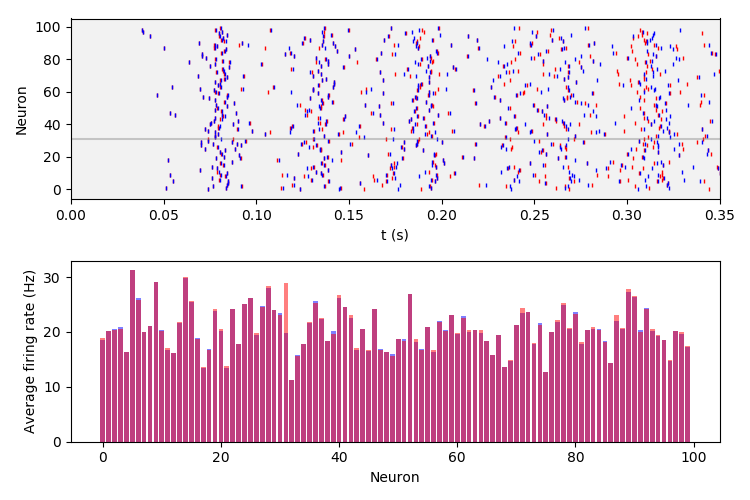

In [18]:
run_example(er_ntwk, [31], -0.06, P, STORE);

<IPython.core.display.Javascript object>


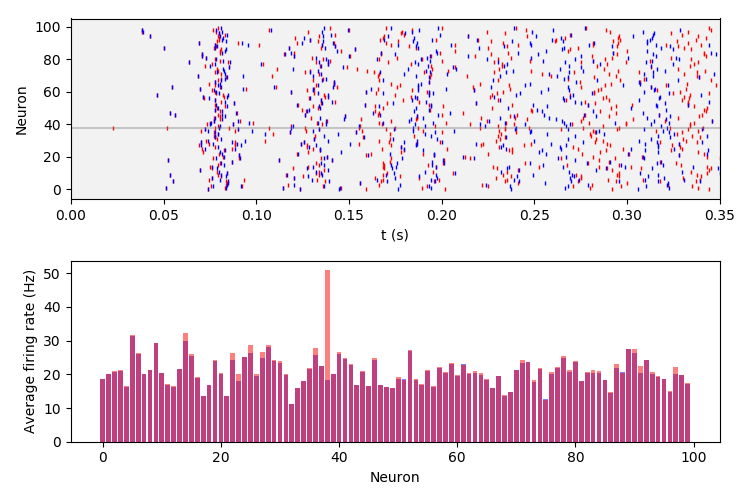

In [19]:
run_example(er_ntwk, [38], -0.05, P, STORE);

In [20]:
import sys

# loop over all neurons in network
STORE = GenericFlexible()

e_leak = -0.05

in_deg = []
out_deg = []

xblt_ifl = []

for nrn in range(P.n):
    
    if nrn % 10 == 0:
        sys.stdout.write('|')
    else:
        sys.stdout.write('.')
        
    rsp_0, rsp_1 = run_e_leak_change_smlns(er_ntwk, [nrn], e_leak, P, STORE)
    
    # a few checks
    ## both ntwks have equal weight matrices
    assert(np.all(rsp_0.ntwk.ws_rcr['E'] == rsp_1.ntwk.ws_rcr['E'].todense()))
    
    ## in & out-degree
    assert((rsp_0.ntwk.ws_rcr['E'][nrn, :] > 0).sum() == STORE.g.in_degree(nrn))
    assert((rsp_0.ntwk.ws_rcr['E'][:, nrn] > 0).sum() == STORE.g.out_degree(nrn))
    
    # store in- & out-degree
    in_deg.append(STORE.g.in_degree(nrn))
    out_deg.append(STORE.g.out_degree(nrn))
    
    # calc & store excitability influence
    fr_0 = get_frs(rsp_0, P)
    fr_1 = get_frs(rsp_1, P)
    
    # mask out neuron whose excitability was changed
    fr_0[nrn] = np.nan
    fr_1[nrn] = np.nan
    
    xblt_ifl.append(np.sqrt(np.nansum((fr_0 - fr_1)**2)))

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

<IPython.core.display.Javascript object>


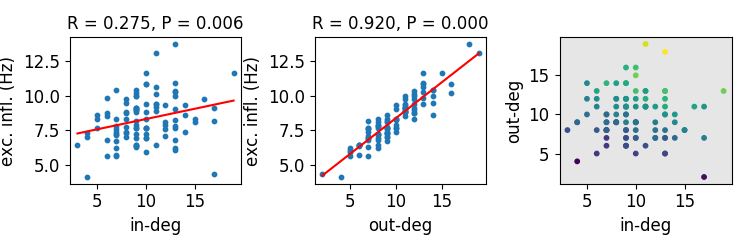

In [21]:
from scipy import stats

# make plots
fig, axs = plt.subplots(1, 3, figsize=(7.5, 7.5/3), tight_layout=True)

axs[0].scatter(in_deg, xblt_ifl, s=10)

r, p = stats.pearsonr(in_deg, xblt_ifl)
slp, icpt = stats.linregress(in_deg, xblt_ifl)[:2]

x = np.array([np.nanmin(in_deg), np.nanmax(in_deg)])
y = slp*x + icpt

axs[0].plot(x, y, c='r')

axs[0].set_xlabel('in-deg')
axs[0].set_ylabel('exc. infl. (Hz)')
axs[0].set_title('R = {0:.3f}, P = {1:.3f}'.format(r, p))

axs[1].scatter(out_deg, xblt_ifl, s=10)

r, p = stats.pearsonr(out_deg, xblt_ifl)
slp, icpt = stats.linregress(out_deg, xblt_ifl)[:2]

x = np.array([np.nanmin(out_deg), np.nanmax(out_deg)])
y = slp*x + icpt

axs[1].plot(x, y, c='r')

axs[1].set_xlabel('out-deg')
axs[1].set_ylabel('exc. infl. (Hz)')
axs[1].set_title('R = {0:.3f}, P = {1:.3f}'.format(r, p))

axs[2].scatter(
    in_deg, out_deg, c=xblt_ifl, s=10, 
    vmin=np.nanmin(xblt_ifl), vmax=np.nanmax(xblt_ifl))

axs[2].set_xlabel('in-deg')
axs[2].set_ylabel('out-deg')
axs[2].set_facecolor((.9, .9, .9))

for ax in axs:
    set_font_size(ax, 12)
pass

## Compare excitability influence distributions between SF & ER networks

<IPython.core.display.Javascript object>


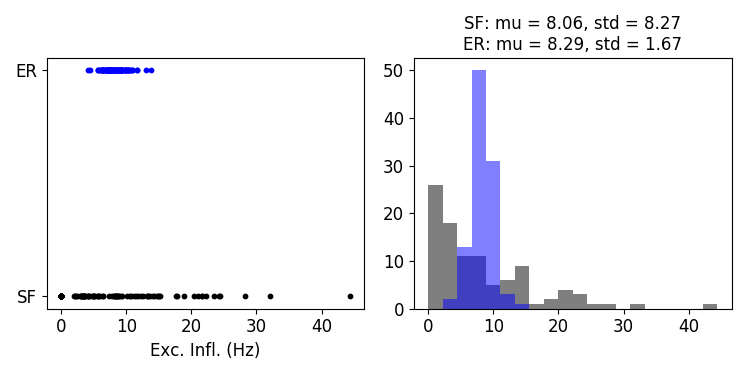

In [33]:
xblt_ifls['er'] = deepcopy(xblt_ifl)

fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.75), tight_layout=True)

axs[0].scatter(xblt_ifls['sf'], np.repeat(0, P.n), c='k', s=10)
axs[0].scatter(xblt_ifls['er'], np.repeat(1, P.n), c='b', s=10)

axs[0].set_xlabel('Exc. Infl. (Hz)')
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(['SF', 'ER'])

bins = np.histogram(xblt_ifls['sf'], bins=20)[1]
axs[1].hist(xblt_ifls['sf'], bins, color='k', alpha=0.5)
axs[1].hist(xblt_ifls['er'], bins, color='b', alpha=0.5)

title = (
    'SF: mu = {0:.2f}, std = {1:.2f}\n'
    'ER: mu = {2:.2f}, std = {3:.2f}'
).format(
    np.mean(xblt_ifls['sf']),
    np.std(xblt_ifls['sf']),
    np.mean(xblt_ifls['er']),
    np.std(xblt_ifls['er']))

axs[1].set_title(title)

for ax in axs:
    set_font_size(ax, 12)